<h2><font color="#004D7F" size=6>Módulo 8. Aprendizaje No Supervisado</font></h2>



<h1><font color="#004D7F" size=5>8.3. Agrupamiento de películas con k-means</font></h1>

<br><br>
<div style="text-align: right">
<font color="#004D7F" size=3>Manuel Castillo-Cara</font><br>
<font color="#004D7F" size=3>Machine Learning con Python</font><br>

---

In [1]:
# Permite ensanchar el área útil de la libreta
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

C:\Users\eel20\AppData\Local\Temp\ipykernel_31916\3915887226.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


---
<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>

* [1. Introducción](#section1)
* [2. La base de datos de películas _MovieLens_](#section2)
* [3. El "genoma" de una película ](#section3)
* [4. Agrupación de películas por similaridad](#section4)
    * [4.1. Descripción de cada grupo](#section41)
    * [4.2. Elementos en cada cluster](#section42)
    * [4.3. _k_ / coste](#section43)
* [5. Práctica](#section5)

---

<a id="section1"></a>
# <font color="#004D7F"> 1. Introducción</font>


En esta libreta se aplicará el algoritmo $k$_-means_ para agrupar un conjunto de 45843 películas. Para ello, se dispone de una representación vectorial de cada una, denominada _genoma_ que representa el grado en que presenta ciertas características, y que permite cuantificar la similaridad. 


<br>
Los clusters obtenidos pueden ser la base de un sencillo sistema de recomendación, en el que se determine qué tipo de películas son las preferidas por un usuario, y se le recomienden películas del mismo grupo.

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---
<a id="section2"></a>

# <font color="#004D7F"> 2. La base de datos de películas _MovieLens_ </font>
<br>

[MovieLens](https://movielens.org/) es una web creada por el grupo [GroupLens](https://grouplens.org/) de la Universidad de Michigan para la investigación en sistemas de recomendación. La plataforma hace las recomendaciones a cada usuario a partir de información que éste proporciona previamente. Esta información es utilizada, a su vez, para alimentar el propio sistema. 

El conjunto de datos `datos/movies.csv` contiene los identificadores y títulos de las 45000 películas incluídas hasta agosto de 2017.

__Nota__: Estos identificadores son independientes de los usados en _IMDb_ o _TMDb_ , aunque existe un conjunto de datos con las correspondencias. 

In [2]:
import pandas as pd
import numpy as np

df_movies = pd.read_csv("datos/datos/movies.csv", sep=',')
df_movies.set_index('movieId', inplace=True)
# Muestra las dos primeras y las dos últimas
display(df_movies.iloc[[0,1, -2,-1]])
# Número de películas (no siguen una secuencia)
print("Número de películas: ",len(df_movies))

,title
movieId,
1,Toy Story (1995)
2,Jumanji (1995)
176275,Satan Triumphant (1917)
176279,Queerama (2017)


Número de películas:  45843


<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---
<a id="section3"></a>

# <font color="#004D7F"> 3. El "genoma" de una película </font>
<br>

Con el fin caracterizar las películas, se creó un conjunto de 1128 etiquetas o palabras clave. Mediante un algoritmo de aprendizaje automático ([enlace](http://files.grouplens.org/papers/tag_genome.pdf)) que toma como entrada contenido elaborado por usuarios -etiquetas, revisiones, etc-  se calculó el _score_ o relevancia de cada etiqueta con respecto a cada película. El archivo `datos/genome-tags.csv` contiene las etiquetas y su identificador.
<br>

__Nota__: Los identificadores las etiquetas siguen una secuencia de 1 a 1128. Para facilitar la indexación en el trabajo posterior se desplazarán las etiquetas, restando uno, de modo que esta secuencia comience en 0, y pueda accederse por posición.

In [4]:
df_tags = pd.read_csv('datos/datos/genome-tags.csv',sep=',')
# Se indexa desde cero
df_tags['tagId']=df_tags['tagId']-1             
df_tags.set_index('tagId', inplace=True)
df_tags.head()

,tag
tagId,
0,007
1,007 (series)
2,18th century
3,1920s
4,1930s


El archivo `datos/genome-scores.csv` contiene los datos sobre el "genoma" para cada película. Igual que en el caso anterior, se modificarán los indentificadores de las etiquetas para que la secuencia de índices comience en cero.

In [5]:
# Lee el conjunto de datos
df_genome = pd.read_csv('datos/datos/genome-scores.zip',sep=',', compression='infer')
# Resta uno a los identificadores de la etiqueta
df_genome['tagId'] = df_genome['tagId'] - 1 
df_genome.head()

,movieId,tagId,relevance
0,1,0,0.02475
1,1,1,0.02475
2,1,2,0.04900
3,1,3,0.07750
4,1,4,0.12450



Cada entrada del conjunto de datos `df_genome` corresponde a la relevancia de un par película/etiqueta. Es posible transformar la tabla de modo que cada fila contenga los datos relativos a una película (cada columna representa una etiqueta) mediante las funciones `DataFrame.pivot_table()` o `DataFrame.unstack()`. En el caso de la segunda, es necesario primero crear un índice jerárquico en el que el primer nivel corresponde al indentificador de la película, y el segundo al identificador de las etiquetas. 

In [6]:
df_genome =  df_genome.pivot_table(index='movieId', columns='tagId', values='relevance')
#df_genome = df_genome.set_index(['movieId', 'tagId']).unstack()
#df_genome.columns = df_genome.columns.droplevel()
df_genome.iloc[[0,-1]]

tagId,0,1,2,3,4,5,6,7,8,9,...,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02475,0.02475,0.049,0.07750,0.12450,0.23875,0.06575,0.28575,0.25400,0.02625,...,0.03125,0.0205,0.04300,0.03375,0.12375,0.0415,0.02125,0.0360,0.10425,0.02750
174585,0.09675,0.07475,0.030,0.03375,0.09275,0.01850,0.03200,0.08125,0.06375,0.02250,...,0.04900,0.1010,0.03925,0.01675,0.41250,0.0775,0.06575,0.0205,0.11775,0.01475



La siguiente celda de código muestra las etiquetas más relevantes (con _score_ más alto) para la primera película del conjunto de datos, _Toy Story_. Para ello, se extraen los identificadores del `DataFrame` `df_genome`, y posteriormente se obtienen las etiquetas de `df_tags`.

In [7]:
print("Título: "+format(df_movies.iloc[0]['title'])+"\n")
print("Etiquetas más relevantes: ")
df_tags.loc[df_genome.iloc[0].sort_values(ascending=False).iloc[:5].index.values]

Título: Toy Story (1995)

Etiquetas más relevantes: 


,tag
tagId,
1035,toys
243,computer animation
785,pixar animation
588,kids and family
63,animation


<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---
<a id="section4"></a>

# <font color="#004D7F"> 4. Agrupación de películas por similaridad </font>
<br>

El "genoma" permite representar cada película mediante un vector. Es posible calcular la similaridad entre pares de películas utilizando una medida de distancia; en este caso, la euclídea. La función `pairwise_distances` del módulo `sklearn.metrics` toma como entrada dos arrays bidimensionales, y calcula las distancias entre elementos de la primera y la segunda. 

En esta celda se obtienen las diez películas más cercanas a _Toy Story_ y se muestran sus títulos. Para ello, se pasa a `pairwise_distances` el conjunto de valores en `df_genomes`, como primer argumento, y una matriz que contiene solo un vector, el "genoma", de _Toy Story_ , como segundo. 

In [8]:
from sklearn.metrics import pairwise_distances

# Obtiene las distancias a Toy Story
distances_ts = pairwise_distances(df_genome.values, [df_genome.values[0,:]], metric='euclidean')
# Obtiene las posiciones de las diez películas más similares y los identificadores
id_movies = df_genome.iloc[np.argsort(distances_ts.squeeze())[:10]].index
# Las muestra
df_movies.loc[id_movies]

,title
movieId,
1,Toy Story (1995)
4886,"Monsters, Inc. (2001)"
3114,Toy Story 2 (1999)
2355,"Bug's Life, A (1998)"
50872,Ratatouille (2007)
78499,Toy Story 3 (2010)
6377,Finding Nemo (2003)
5218,Ice Age (2002)
42191,Luxo Jr. (1986)



La existencia de una medida de similaridad entre películas permite utilizar el algorimto $k$_-means_ para construir grupos. En la siguiente celda, se utilizará esta información para categorizar las películas en (por ejemplo) 15 grupos. 

In [9]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=15, init='k-means++', max_iter=500, random_state=0)
km.fit(df_genome)

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=500, n_clusters=15, random_state=0)

Como resultado del proceso de agrupamiento se devuelven:

* El centroide de cada cluster, que corresponde a un vector con la relevancia media de las películas del cluster con respecto a cada etiqueta. 
* El índice del cluster al que se ha asignado cada película. 
<br>

---
<a id="section41"></a>

## <font color="#004D7F"> 4.1. Descripción de cada grupo </font>
<br>

En muchas situaciones, el paso posterior al proceso de clustering consiste en elaborar una descripción de los elementos que pertenecen a cada grupo. En el caso de $k$-_means_ , ésta viene dada, en parte, por el centroide. En este contexto, el centroide representa la relevancia media de cada etiqueta para las películas que corresponden a un grupo.  Las etiquetas con mayor valor, que son las más importantes, permiten determinar qué tipo de películas corresponden a un grupo determinado.  

En esta celda se muestran las 20 etiquetas con más peso para el primer grupo (por ejemplo).Introducción

In [10]:
# Extrae los centroides
k_centers = km.cluster_centers_

# Extrae el centroide de un cluster, por ejemplo el primero.
sel_cluster = 0
centroid = k_centers[sel_cluster,:]
print("Centroide :"+str(centroid))

# Extrae las 20 etiquetas con más score y las muestra
ord_tags = np.argsort(centroid)[::-1]
cluster_tags = df_tags.iloc[ord_tags[0:20]]
cluster_tags

Centroide :[0.11554948 0.09918142 0.04736198 ... 0.01961806 0.12603863 0.03921267]


,tag
tagId,
18,action
446,good action
388,fight scenes
741,original
19,action packed
194,chase
645,mentor
776,pg-13
301,dialogue


---

Es posible mostrar las etiquetas de un modo más original, mediante una nube de palabras.

In [11]:
#!pip install wordcloud

     ---------------------------------------- 0.0/153.3 kB ? eta -:--:--
     -------------------------------------- 153.3/153.3 kB 8.9 MB/s eta 0:00:00


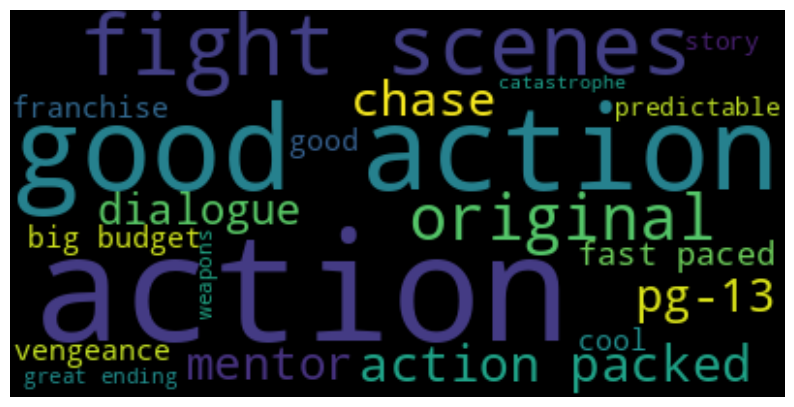

In [13]:
# Extrae las etiquetas
text = cluster_tags['tag'].values
# Extrae los scores
id_tags = cluster_tags.index
scores = centroid[id_tags]

# Muestra una nube de palabras
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Crea un diccionario con las palabras y sus scores (como enteros)
scores = (scores*100).astype(int)
tag_scores = dict(zip(text,scores))

# Genera la nube de palabras
wordcloud = WordCloud().generate_from_frequencies(tag_scores)

# La muestra
fig = plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

---
<a id="section42"></a>
## <font color="#004D7F"> 4.2. Elementos en cada cluster </font>
<br>

Una vez hechos y caracterizados los grupos, es posible acceder a las películas que los forman. Para ello, es necesario extraer primero los identificadores, y posteriormente acceder al `DataFrame` `df_movies`.

In [14]:
# Obtiene las etiquetas para cada caso
clusters = km.labels_
# Obtiene las películas (posiciones) correspondientes al primer cluster
movies_sel_cluster = np.arange(clusters.shape[0])[clusters==sel_cluster]
# Obtiene los identificadores de las películas
id_movies = df_genome.iloc[movies_sel_cluster].index
# Muestra los diez primeros
df_movies.loc[id_movies].head(10)

,title
movieId,
9,Sudden Death (1995)
10,GoldenEye (1995)
15,Cutthroat Island (1995)
23,Assassins (1995)
44,Mortal Kombat (1995)
95,Broken Arrow (1996)
112,Rumble in the Bronx (Hont faan kui) (1995)
145,Bad Boys (1995)
153,Batman Forever (1995)


---
<a id="section43"></a>
## <font color="#004D7F"> 4.3. Coste/k </font>
<br>
El número de grupos en el que se han dividido las películas en el ejemplo, 15, se ha establecido de manera arbitraria. La curva coste/k puede ayudar a establecer este grupo. Para ello, es necesario primero implementar la función de coste.

In [15]:
def cost(data, k, centroids, clusters):
    cost = 0.0
    for c in range(k):
        points_cluster = data[clusters==c, :]
        if points_cluster.shape[0] > 0: 
            distances = pairwise_distances(points_cluster, [centroids[c]], metric='euclidean')
            cost += np.sum(distances**2)
    return cost/len(clusters)

<br>

Para estimar el número adecuado de clusters en función del coste, es necesario repetir el proceso para un rango de valores de $k$. Como se ha visto anteriormente, la ejecución de `Kmeans` sobre el conjunto de datos `df_genome` requiere varios segundos.  En la práctica anterior se recurrió al muestreo para acelerar el algoritmo. Otra posibilidad consiste en utilizar, en lugar de `Kmeans` la versión `MiniBatchKMeans`.

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


0,

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


1,

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


2,

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


3,

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


4,

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


5,

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


6,

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


7,

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


8,

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


9,

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


10,

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


11,

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


12,

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


13,

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


14,

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


15,

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


16,

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


17,

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


18,

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


19,

C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\eel20\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


20,

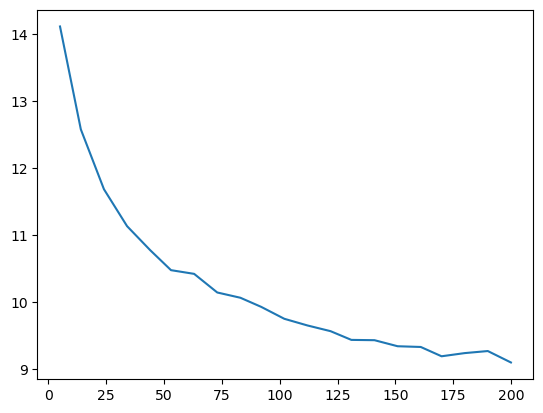

In [16]:
from sklearn.cluster import MiniBatchKMeans

# Guarda los costes
costs = np.zeros(21,)
# Valores de k de 5 a 125
ks = np.linspace(5,200,21).astype(int)

# Ejecuta k-means para cada valor de k, y guarda el coste asociado
for i,k in enumerate(ks):
    kmeans = MiniBatchKMeans(n_clusters=k, init='k-means++', max_iter=500)    
    kmeans.fit(df_genome.values)
    centroids = kmeans.cluster_centers_
    clusters = kmeans.labels_
    costs[i] = cost(df_genome.values, k, centroids, clusters)
    print(i,end=',')
    
plt.plot(ks,costs);    

<br> 

Puede observarse que el cambio de tendencia no es tan acusado como en la práctica anterior, por lo que es más difícil determinar cual es el valor óptimo, ya que este debería estar en un punto entre 20 y 100.

<br>
En este caso, y en otros muchos, esta elección puede no seguir un criterio estrictamente numérico. Por ejemplo, si se utilizan 100 grupos, estos son más específicos. Sin embargo, puede ser que en un determinado contexto, esta división sea excesiva. 

In [24]:
# Crea el objeto k-means
km = MiniBatchKMeans(n_clusters=100, init='k-means++', max_iter=500, random_state=0)
# Ejecuta k-means sobre el cojunto de datos df_genome
km.fit(df_genome)

# Extrae los centroides
k_centers = km.cluster_centers_

# Extrae el centroide de un cluster, por ejemplo el primero.
sel_cluster = 6
centroid = k_centers[sel_cluster, :]
print("Centroide :"+str(centroid))

# Extrae las 30 etiquetas con más score y las muestra
ord_tags = np.argsort(centroid)[::-1]
cluster_tags = df_tags.iloc[ord_tags[0:20]]
cluster_tags

Centroide :[0.03982673 0.03996535 0.06018564 ... 0.08273762 0.08051733 0.02540842]


,tag
tagId,
971,storytelling
741,original
464,great acting
998,suspense
467,great ending
535,imdb top 250
1050,twists & turns
1019,tense
239,complex


<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section5"></a>

# <font color="#004D7F"> 5. Práctica</font>
<br>

Como se ha podido ver los algoritmos de aprendizaje no supervisado son una gran herramienta para establecer clases en datos no etiquetados. Además, en esta práctica se ha visto únicamente el algoritmo $k$-means, por lo que se pide:
1. Utilizar el algoritmo clustering jerárquico y comparar el rendimiento con $k$-means.
2. Utilizar el algoritmo basado en conectividad DBSCAN y comparar el rendimiento con $k$-means.
3. Utilizar un algoritmo basado en conectividad diferente a DBSCAN y comparar el rendimiento con los anteriores.

<div style="text-align: left"><font size=4> <i class="fa fa-check-square-o" aria-hidden="true" style="color:#113D68"></i></font></div>

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>